## About
This analysis script lets you post-process the TMaMD results. You require:
- `{workdir}/data/pyrosetta/combined.out`
- `{workdir}/data/iter*/mount/xtc/*`<br/>
from the runs.
- Reference PDB structure (clean - only RNA present) to compare

**Note:** Some parts of this code may be sensitive to the RNA chosen. These regions are marked out with a <i>'#TODO: Change accordingly'</i> tag

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import os
%run ../PyRosetta/General.ipynb

/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.08+release.717d2e8232174371f0c672564f23a097062db88a 2024-02-21T10:16:44] retrieved from: http://www.pyrosetta.org


### Setting root dir
This is where all your 'iter' folders are present.

In [2]:
ROOT_DIR="/home/venkata/python/PyRosetta/R1107/server/example5/" #TODO: Change Accordingly
sorted(os.listdir(ROOT_DIR))

['get_TMaMD_files.sh',
 'iter0',
 'iter1',
 'iter2',
 'iter3',
 'iter4',
 'iter5',
 'iter6',
 'iter7',
 'rosetta']

## Picking the reference
There are **two** use cases here. Pick the next cell based on which mode you want to run in

### Crystal Structure PDB
Run the next cell if you want to comapre RMSD to <b>Experimental Crystal Structure PDB</b>

In [3]:
ref_pose=LoadedPDB(ROOT_DIR+"../../7qr4_clean_noprotein.pdb") #TODO: Change accordingly (Path to your crystal PDB)
ANALYSIS_TYPE="crystal"
ref_xyz=get_torch_rep(ref_pose,ignore_Hs=True).detach().cpu().numpy()

### Rosetta Best PDB
Run the next cell if you want to compare RMSD of TMaMD MD runs to <b>Rosetta's best prediction</b>

In [ ]:
ref_pose=LoadedPDB(ROOT_DIR+"/rosetta/crystal_closest.pdb") #Picks up the rosetta best crystal structure
# Note: You need to generate this by doing the rosetta analysis. Look at the Rosetta_PostProcess.ipynb file for this
ANALYSIS_TYPE="rosetta"
ref_xyz=get_torch_rep(ref_pose,ignore_Hs=True).detach().cpu().numpy()

### Next Steps

#### Locating the 'iter' folders

In [4]:
iter_fols=np.array(sorted([dir for dir in os.listdir(ROOT_DIR) if dir.startswith("iter")]),dtype=str)
SKIP_LAST=False #TODO: Change accordingly (Useful if the simulations were stopped midway, so last iteration did not complete)
print(iter_fols)

['iter0' 'iter1' 'iter2' 'iter3' 'iter4' 'iter5' 'iter6' 'iter7']


#### Using any 'top.pdb' as the template frame to get atoms

In [5]:
template_frame=mda.Universe(ROOT_DIR+"/"+"iter0"+"/mount/xtc/top.pdb")
# Picks non-hydrogen atoms
crds=np.array([template_frame.atoms[i].name.strip()[0]!="H" for i in range(len(template_frame.atoms))],dtype=bool)
print(get_torch_rep(ref_pose)[4:].shape[0],"atoms in reference PDB")
print(crds.sum(),"in MD trajectory frame object")

#Note: In R1107, there was an extra atom in reference PDB. This is generally possible with variable capping conventions (terminal phosphates and oxygen atoms)

1462 atoms in reference PDB
1461 in MD trajectory frame object


#### Pick atoms and match-up
Picking only heavy atoms for RMSD calculation. Need to match-up all the atoms 1-1 before alignment

In [6]:
# Pick all heavy atoms from template frame
sel_mda=np.array([a.name.strip() for a in template_frame.atoms[crds]],dtype=str)

# Pick all heavy atoms from reference structure
sel_ref=ref_pose.get_atom_names(ignore_Hs=True,stripped=True)[4:] # TODO: Change accordingly - Check capping

# Dropping index 19 due to capping differences - TODO: Change accordingly
# (You only need whatever goes below this if there are unequal atoms in reference and MD poses. Then you will have to manually sort-out the capping disagreement)
drop_indices=[19]

sel_mda=np.delete(sel_mda,drop_indices) # Capping differences

# Quality checks (Elements and sizes should match-up)
print(sel_mda[0],sel_ref[0],sel_mda.shape,sel_ref.shape)
matching=(sel_mda[:len(sel_ref)]==sel_ref[:len(sel_mda)]) # Automatic truncation to smaller size
print(np.unique(matching)) # Should print out only '[True]' (no false). This indicates that the atom-types match-up identically, so now we can align the structures

C5' C5' (1460,) (1460,)
[ True]


In [7]:
# Create a bitmap for heavy atoms of the reference pose
ref_sel=np.zeros(ref_pose.get_atom_count(),dtype=bool)
ref_sel[non_hydrogen_indices(ref_pose)[4:]]=1.

# Dropping indices due to capping differences - TODO: Change accordingly
# (You only need whatever goes below this if there are unequal atoms in reference and MD poses. Then you will have to manually sort-out the capping disagreement)
drop_indices=[]
ref_sel[drop_indices]=False

In [8]:
md_sel=np.array([template_frame.atoms[i].name.strip()[0]!="H" for i in range(len(template_frame.atoms))],dtype=bool)

# Dropping indices due to capping differences - TODO: Change accordingly
# (You only need whatever goes below this if there are unequal atoms in reference and MD poses. Then you will have to manually sort-out the capping disagreement)
drop_indices=[30]
md_sel[drop_indices]=False # Capping differences

#### Sanity check before alignment

In [9]:
print(md_sel.sum(),"atoms selected from template PDB")
print(ref_sel.sum(),"atoms selected from reference PDB")
print(len(np.where(np.array([a.name.strip() for a in template_frame.atoms[md_sel]],dtype=str)[:1460]!=(ref_pose.get_atom_names()[ref_sel]))[0]),"mismatches between ref and template")
# You should equal atoms for both cases and 0 mismatches!

1460 atoms selected from template PDB
1460 atoms selected from reference PDB
0 mismatches between ref and template


### Coordinates

In [10]:
# Collecting selected atom coordinates from reference template
ref_xyz=get_torch_rep(ref_pose,ignore_Hs=False)[ref_sel].detach().cpu().numpy()

#### Align and compare RMSD

In [11]:
for fol in iter_fols:
    # Go through each iteration (folder-wise)
    folpath=ROOT_DIR+"/"+fol+"/mount/xtc/"
    print(fol,end=": ")
    cluster_id=[]
    cluster_rmsds=[]
    # Go through each cluster for that iteration
    clusters=sorted([fol for fol in os.listdir(folpath) if fol.endswith(".xtc")])
    for cluster in clusters:
        # Pick only xtc files
        if not cluster.endswith(".xtc"): continue
        cluster_rmsds.append([])
        cluster_id.append(cluster)
        
        # Load the trajectory
        traj=mda.coordinates.XTC.XTCReader(folpath+"/"+cluster)

        # For each structure in the cluster
        for i,frame in enumerate(traj):
            # Align and get RMSD value
            rmsd_val=align.rms.rmsd(frame.positions[md_sel],ref_xyz,superposition=True)
            cluster_rmsds[-1].append(rmsd_val)
    # Clusters will not be loaded in order, so the order is also saved here if ever needed for a cluster-level analysis
    cluster_id=np.array(cluster_id,dtype=str)
    cluster_rmsds=np.array(cluster_rmsds,dtype=object) # Data will be saved as a list of np.array objects. Remember to load with 'allow_pickle=True'

    # Save the data
    if ANALYSIS_TYPE=="rosetta":
        np.save(ROOT_DIR+"/"+fol+"/cluster_ids_to_rosetta.npy",cluster_id)
        np.save(ROOT_DIR+"/"+fol+"/cluster_rmsds_to_rosetta.npy",cluster_rmsds)
    else:
        np.save(ROOT_DIR+"/"+fol+"/cluster_ids",cluster_id)
        np.save(ROOT_DIR+"/"+fol+"/cluster_rmsds.npy",cluster_rmsds)
    print("Done") # Signals the end of processing each iteration

iter0: Done
iter1: Done
iter2: Done
iter3: Done
iter4: Done
iter5: Done
iter6: Done
iter7: Done


### Analysis

In [12]:
# Printing to make sure you remember which version is being run
print("Analysis type:",ANALYSIS_TYPE)
LEN_LIM=len(iter_fols)-1 if(SKIP_LAST) else len(iter_fols)
print("Going upto iter",LEN_LIM-1)

Analysis type: crystal
Going upto iter 7


#### Compute statistics
This part will compute the best structure per iteration (by RMSD minimum) and the mean/median performance of each iteration.</br>
You can add any other metrics you think are relavent here

In [13]:
minimums=[]
means=[]
medians=[]
raw_data=[]


for fol in iter_fols:
    # Load the correct data file
    if ANALYSIS_TYPE=="crystal": filepath=ROOT_DIR+"/"+fol+"/cluster_rmsds.npy"
    else: filepath=ROOT_DIR+"/"+fol+"/cluster_rmsds_to_rosetta.npy"

    
    data=np.load(filepath,allow_pickle=True) # Remember to load with allow_pickle=True
    data=np.concatenate(list(data)) # Mix up all clusters, we only want the structures

    # Calculate statistics: TODO - Change accordingly (Optionally, with tweaks to the array names above and functions below, you can add more statistics)
    minimums.append(np.min(data))
    means.append(np.mean(data))
    medians.append(np.median(data))
    raw_data.append(data)
minimums=np.array(minimums)[:LEN_LIM]
means=np.array(means)[:LEN_LIM]
medians=np.array(medians)[:LEN_LIM]

# Get the best RMSD at each iteration
print("Minimums for each iteration:")
for it in range(len(minimums)):
    print(it,np.round(minimums[it],3))

Minimums for each iteration:
0 3.073
1 2.787
2 3.195
3 3.288
4 3.728
5 3.539
6 3.342
7 3.478


### Best structure for each iteration
This is to dump the best structure at each iteration (by RMSD)

In [14]:
# Choose dump name based on analysis type
if ANALYSIS_TYPE=="crystal": outfile="TM_MD_best_expt.pdb"
else: outfile="TM_MD_best_rosetta.pdb"
print(outfile)

TM_MD_best_expt.pdb


In [15]:
for i,it in enumerate(iter_fols):
    minstruct_idx=np.argmin(raw_data[i])
    print("Minimum RMSD structure is at index:",minstruct_idx)

    # Recall the order in which clusters were loaded
    cluster_ids=np.load(ROOT_DIR+"/"+it+"/cluster_ids.npy")
    req_id=minstruct_idx
    for cluster in cluster_ids:
        traj=mda.coordinates.XTC.XTCReader(ROOT_DIR+"/"+it+"/mount/xtc/"+cluster)
        # Skip each cluster until the one with the best structure is found
        req_id-=len(traj)

        # When the cluster is found - Stop
        if req_id<0: break
    else:
        print("ERR: Search failed")
        raise ValueError("Structure was not found on iteration "+str(it))
    print(cluster,"is the file with the best pose (by RMSD) for iteration",it,"\n")
    print("Final RMSD:",align.rms.rmsd(traj[req_id].positions[md_sel],ref_xyz,superposition=True))

    # Save the structure
    template_frame.atoms.positions=traj[req_id].positions
    mda.Writer(ROOT_DIR+"/"+it+"/"+outfile,multiframe=False).write(template_frame)

Minimum RMSD structure is at index: 4621
cluster4.xtc is the file with the best pose (by RMSD) for iteration iter0 

Final RMSD: 3.07260896167864
Minimum RMSD structure is at index: 8504
cluster19.xtc is the file with the best pose (by RMSD) for iteration iter1 

Final RMSD: 2.78739287521633
Minimum RMSD structure is at index: 6163
cluster18.xtc is the file with the best pose (by RMSD) for iteration iter2 

Final RMSD: 3.195375187613351
Minimum RMSD structure is at index: 747
cluster-1.xtc is the file with the best pose (by RMSD) for iteration iter3 

Final RMSD: 3.28758178740587
Minimum RMSD structure is at index: 8922
cluster17.xtc is the file with the best pose (by RMSD) for iteration iter4 

Final RMSD: 3.7283648975506645
Minimum RMSD structure is at index: 9276
cluster21.xtc is the file with the best pose (by RMSD) for iteration iter5 

Final RMSD: 3.5385039244730208
Minimum RMSD structure is at index: 20449


/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


cluster26.xtc is the file with the best pose (by RMSD) for iteration iter6 

Final RMSD: 3.3416680802255248
Minimum RMSD structure is at index: 24643
cluster5.xtc is the file with the best pose (by RMSD) for iteration iter7 

Final RMSD: 3.4783781635381694


#### Draw the average RMSD with iterations

(array([5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5]),
 [Text(0, 5.5, '5.5'),
  Text(0, 6.0, '6.0'),
  Text(0, 6.5, '6.5'),
  Text(0, 7.0, '7.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 8.0, '8.0'),
  Text(0, 8.5, '8.5')])

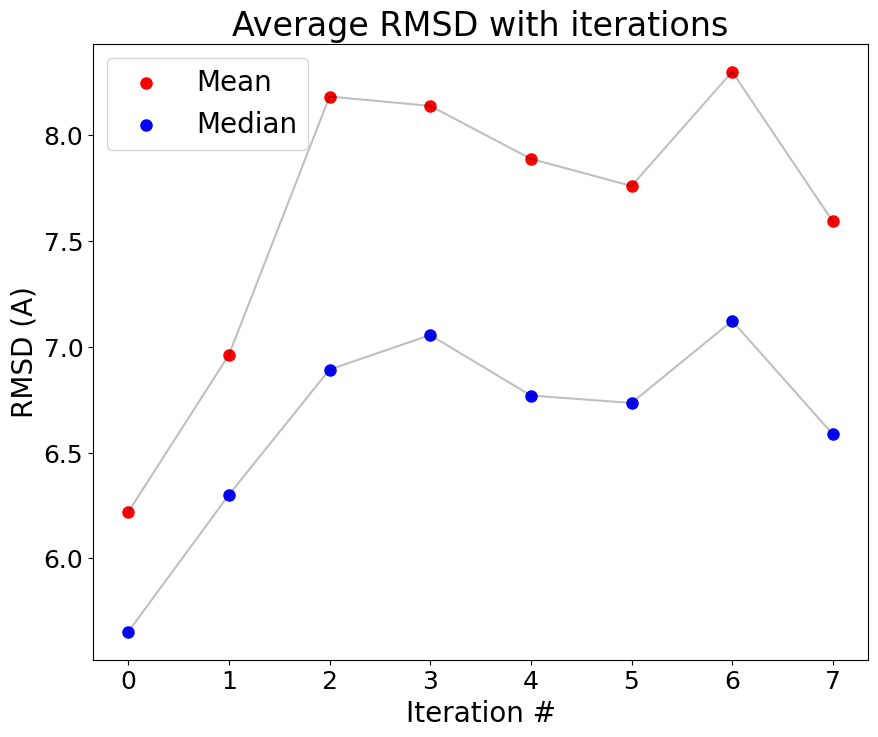

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(means)),means,c='k',alpha=0.25)
plt.plot(np.arange(len(medians)),medians,c='k',alpha=0.25)
plt.scatter(np.arange(len(means)),means,c='r',s=64,label="Mean")
plt.scatter(np.arange(len(medians)),medians,c='b',s=64,label="Median")
plt.legend(fontsize=20)
plt.title("Average RMSD with iterations",fontsize=24)
plt.xlabel("Iteration #",fontsize=20)
plt.xticks(np.arange(len(means)),np.arange(len(means)),fontsize=18)
plt.ylabel("RMSD (A)",fontsize=20)
plt.yticks(fontsize=18)
#plt.plot(medians)

#### Draw a box plot of RMSD for each iteration

(0.0, 25.0)

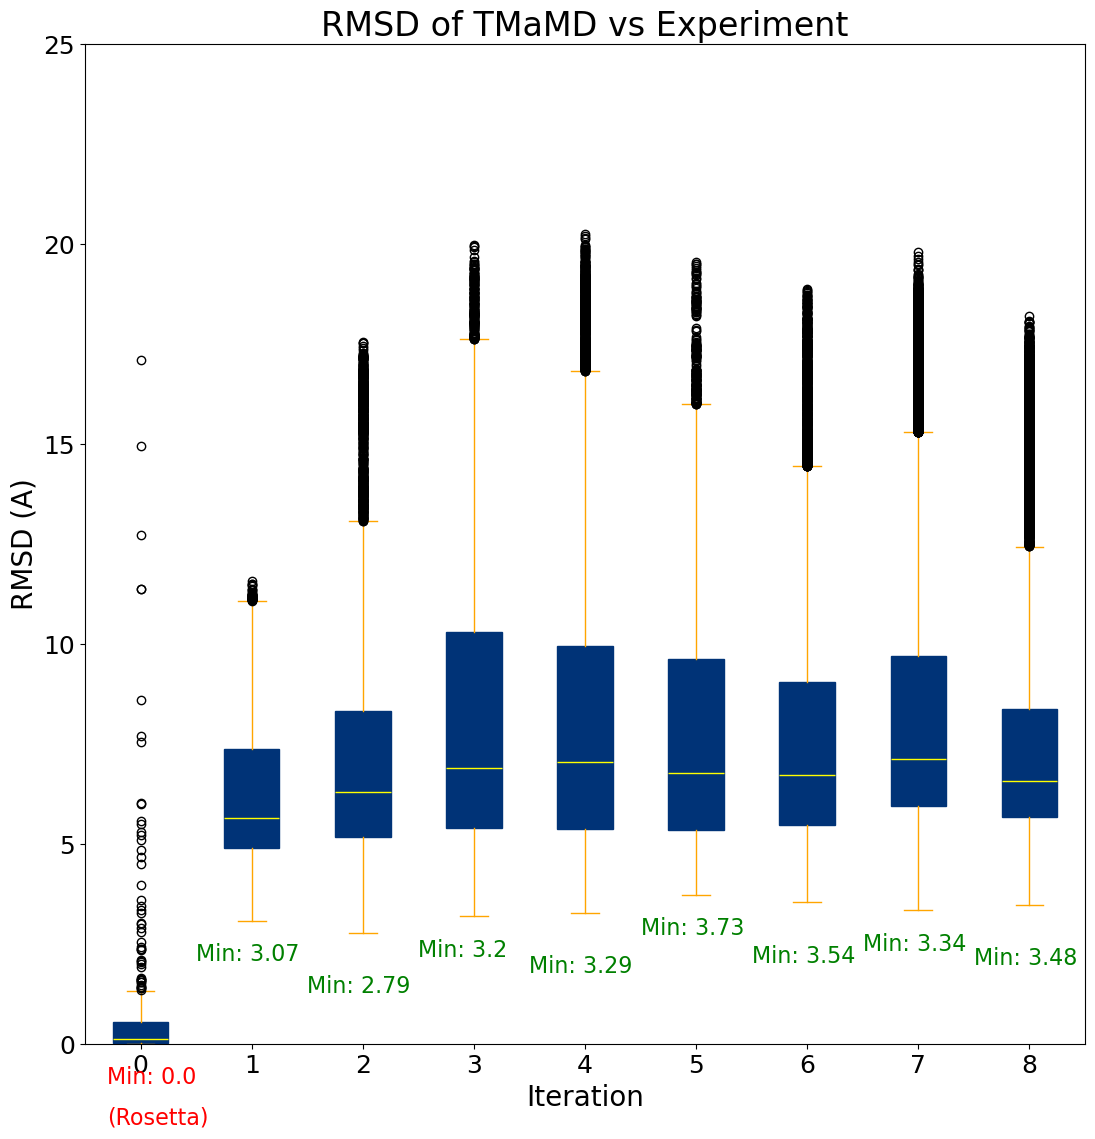

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
ax = plt.axes((0, 0, 1, 1))

BASELINE=False
Y_SHIFT=1.0 # TODO: Change accordingly (will depend on RMSD ranges. This determines where the text will go on screen)
EXTRA_SHIFT=0.5 # TODO: Change accordinly (Can change to make a good-looking plot. Staggers the text to space it)

# Optional section: TODO: Change accordingly (Only use if you want to add a baseline)
BASELINE=True
#baseline_rmsd=np.load(ROOT_DIR+"../../baseline_rmsds.npy")
baseline_rmsd=np.load(ROOT_DIR+"/rosetta/RMSD_crystal.npy")
baseline_rmsd=baseline_rmsd[~np.isnan(baseline_rmsd)]
ax.text(0.70,np.min(baseline_rmsd)-Y_SHIFT, "Min: "+str(round(np.min(baseline_rmsd),2)), fontsize=16, color='red')
ax.text(0.70,np.min(baseline_rmsd)-Y_SHIFT-1.0, "(Rosetta)", fontsize=16, color='red')
# End optional section

for i in range(len(minimums)):
    ax.text((1.50 if BASELINE else 0.5)+i,minimums[i]-Y_SHIFT-(i%2)*EXTRA_SHIFT, "Min: "+str(round(np.min(raw_data[i]),2)), fontsize=16, color='green')

if BASELINE: bplot=plt.boxplot([baseline_rmsd]+raw_data[:LEN_LIM],patch_artist=True,notch=False)
else: bplot=plt.boxplot(raw_data[:LEN_LIM],patch_artist=True,notch=False)
    
for i in range(len(bplot["boxes"])):
    bplot["boxes"][i].set_color("#003377")
    bplot["medians"][i].set_color("yellow")
[whisk.set_color("orange") for whisk in bplot["whiskers"]]
[whisk.set_color("orange") for whisk in bplot["caps"]]

if ANALYSIS_TYPE=="crystal": plt.title("RMSD of TMaMD vs Experiment",fontsize=24)
else: plt.title("RMSD of TMaMD vs Rosetta best",fontsize=24)
plt.yticks(fontsize=18)
plt.ylabel("RMSD (A)",fontsize=20)
plt.xticks(np.arange(len(bplot["boxes"]))+1,np.arange(len(bplot["boxes"])),fontsize=18)
plt.xlabel("Iteration",fontsize=20)
plt.ylim(0,25) # TODO: Change accordingly. (You can play with it to get a good looking plot.

### Extras
Compare RMSD of the CASP15 best structure to the experimental stucture. You need:
- Crystal structure of predicted best pose

In [ ]:
ANALYSIS_TYPE="crystal"

In [ ]:
if ANALYSIS_TYPE!="crystal":
    print("WARN: You are comparing CASP best structure to rosetta prediction - not experimental pose")
    print("Rerun in 'crystal' analysis mode to get comparison to experimental pose")

In [ ]:
CASP_pred=LoadedPDB(ROOT_DIR+"../../CASP15_best.pdb") # TODO: Change accordingly 
aligned_CASP=align_poses(ref_pose,CASP_pred,silent=True,max_iter=1000,step_size=1e-1)
print("RMSD:",get_rmsd(ref_pose,aligned_CASP))